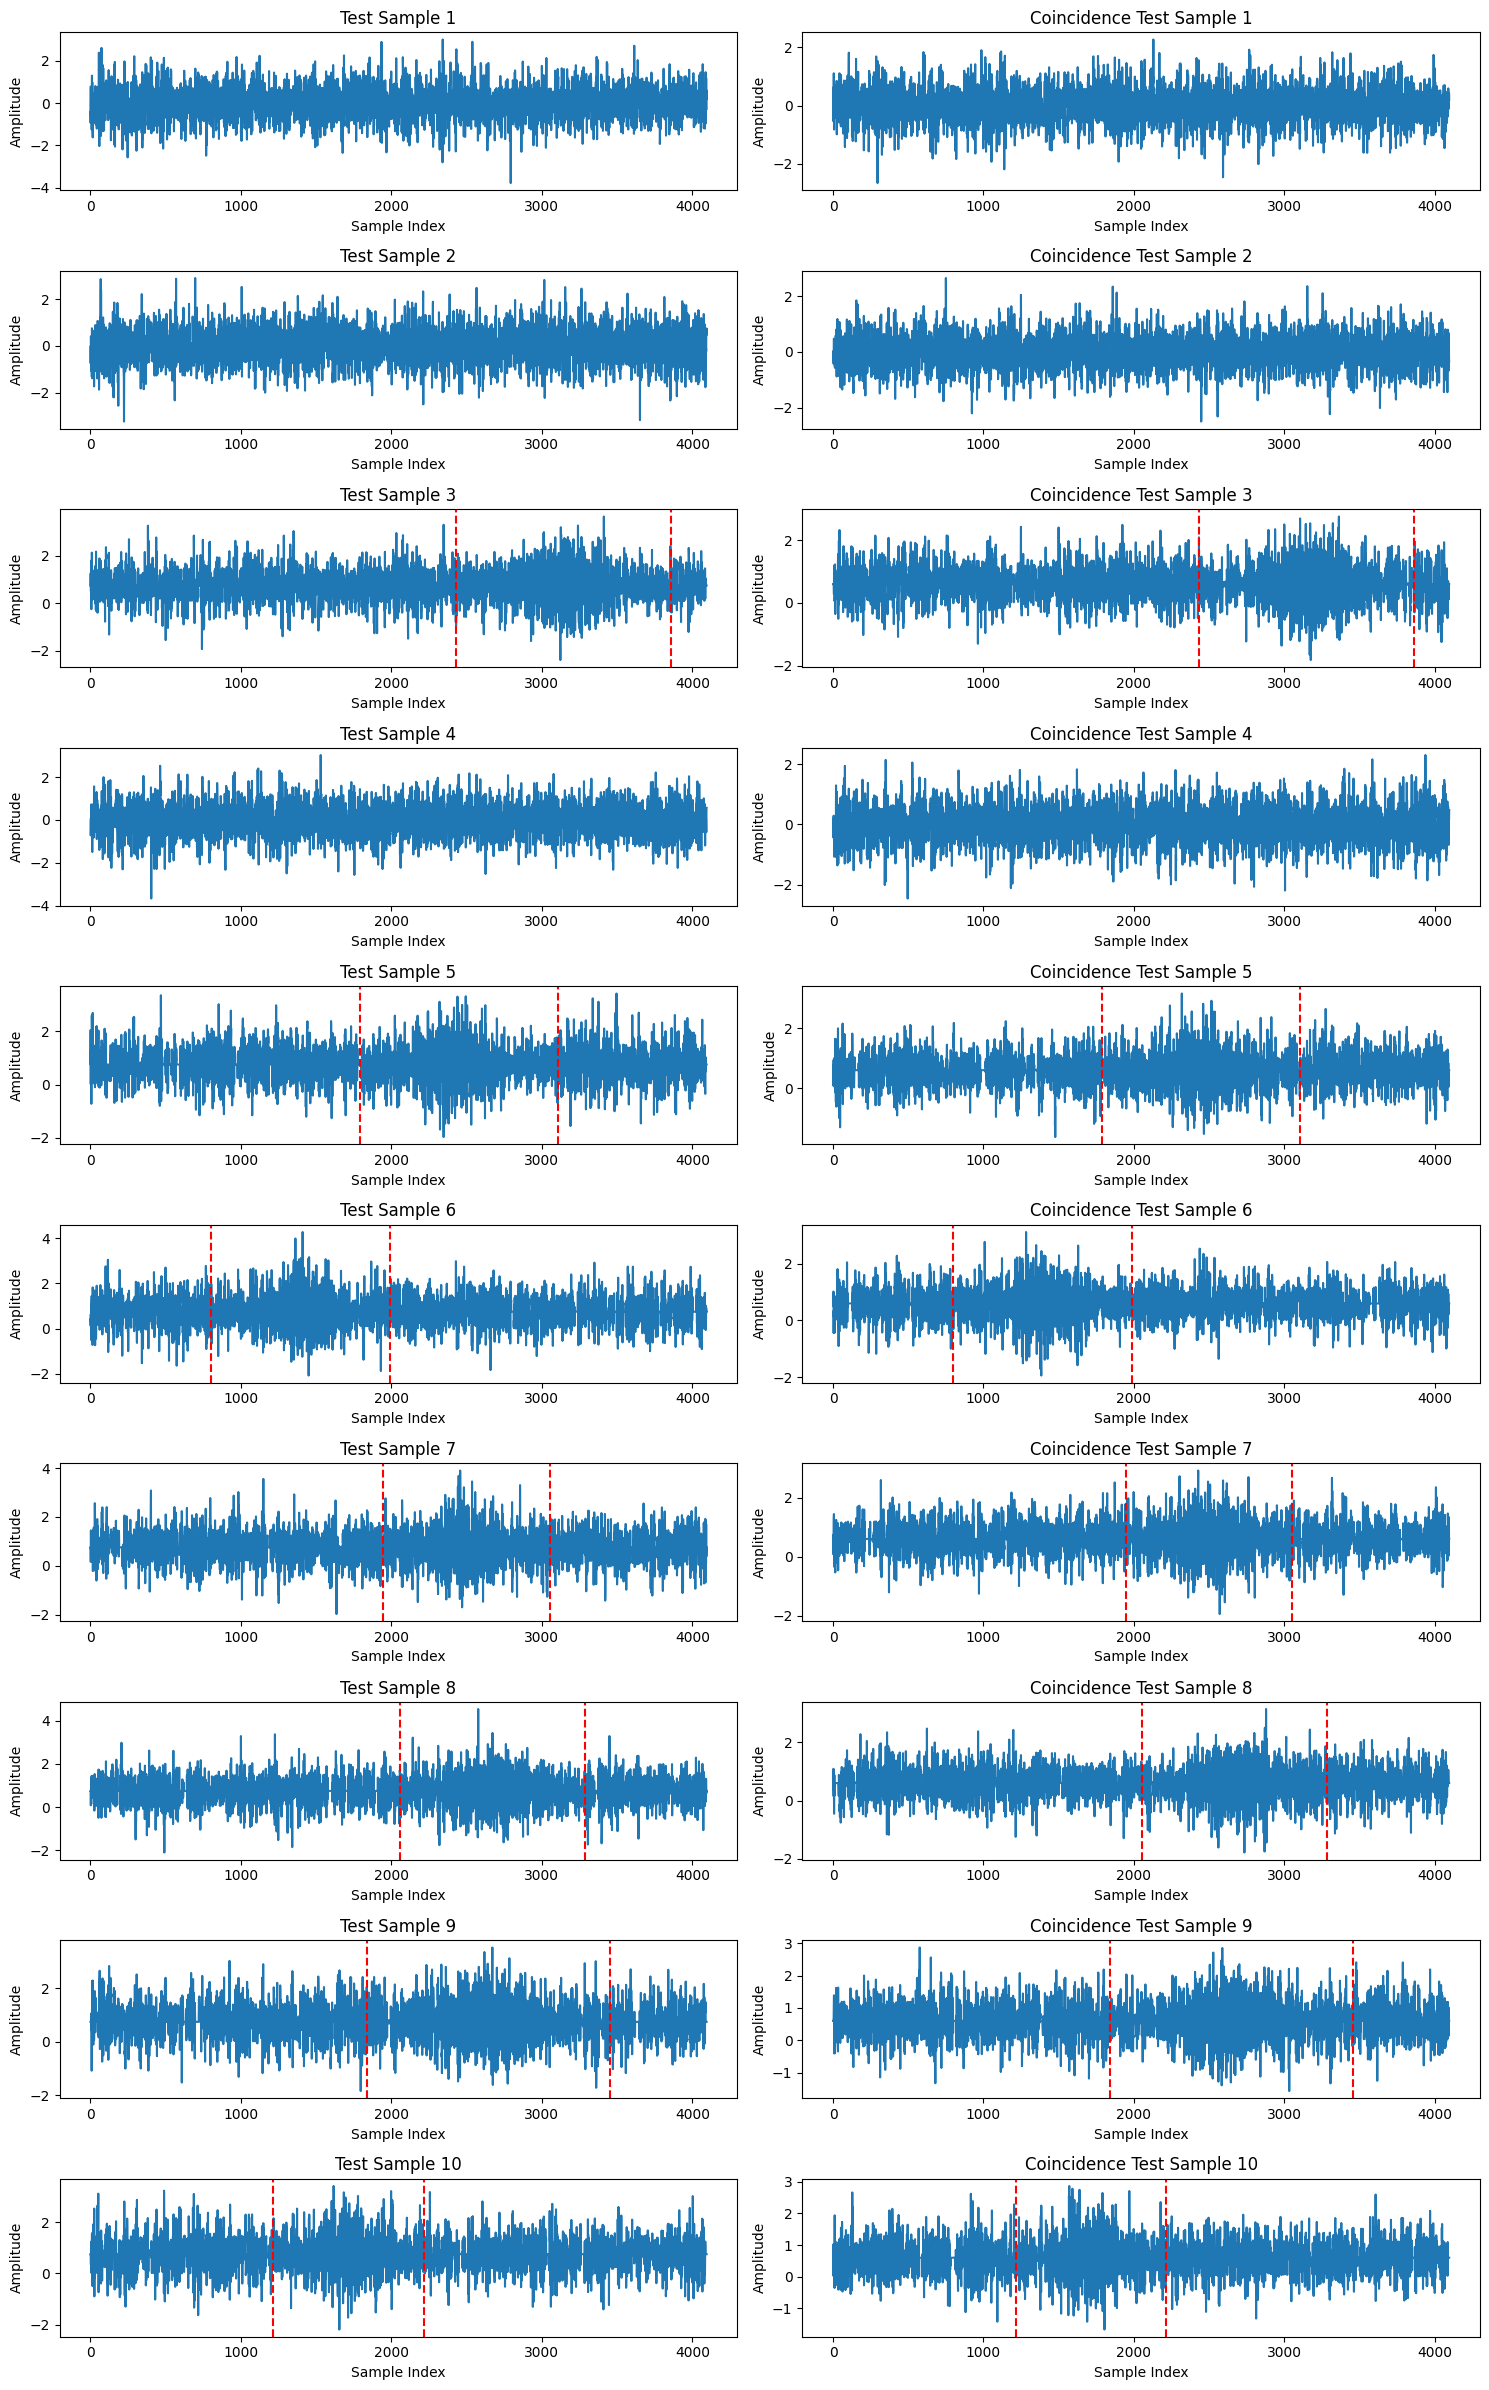

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function Definitions

def sine_gaussian_waveform(t, A, t0, tau, f0, phi0):
    gaussian_envelope = A * np.exp(-((t - t0)**2) / (2 * tau**2))
    sine_wave = np.cos(2 * np.pi * f0 * t + phi0)
    return gaussian_envelope * sine_wave

def add_glitches(signal, glitch_frequency, glitch_amplitude, glitch_duration, num_points):
    signal_with_glitches = signal.copy()
    for _ in range(int(glitch_frequency * num_points)):
        start_idx = np.random.randint(0, num_points - glitch_duration)
        end_idx = start_idx + glitch_duration
        glitch = np.random.uniform(-glitch_amplitude, glitch_amplitude, glitch_duration)
        signal_with_glitches[start_idx:end_idx] += glitch
    return signal_with_glitches

def generate_waveform_data(num_samples, num_points, A_base, A_variation, t0_base, t0_variation, tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, time_length_base, time_length_variation, glitch_frequency=0.0, glitch_amplitude=0.0, glitch_duration=0, signal_present=True):
    data = []
    labels = []
    signal_params = []

    for _ in range(num_samples):
        A = A_base + np.random.uniform(-A_variation, A_variation)
        t0 = t0_base + np.random.uniform(-t0_variation, t0_variation)
        f0 = f0_base + np.random.uniform(-f0_variation, f0_variation)
        noise_level = noise_level_base + np.random.uniform(-noise_variation, noise_variation)
        time_length = time_length_base + np.random.uniform(-time_length_variation, time_length_variation)
        
        t = np.linspace(0, time_length, num_points)

        if signal_present:
            waveform = sine_gaussian_waveform(t, A, t0, tau, f0, phi0)
            signal_with_noise = waveform + noise_level
            label = np.zeros_like(t)
            signal_start = np.argmin(np.abs(t - t0 + 3 * tau))
            signal_end = np.argmin(np.abs(t - t0 - 3 * tau))
            label[signal_start:signal_end] = 1
        else:
            signal_with_noise = np.random.uniform(-noise_level, noise_level, t.shape)
            label = np.zeros_like(t)

        if glitch_frequency > 0:
            signal_with_noise = add_glitches(signal_with_noise, glitch_frequency, glitch_amplitude, glitch_duration, num_points)
        
        data.append(signal_with_noise)
        labels.append(label)
        signal_params.append((t0, A, t, f0))  # Save parameters for later use
    
    return np.array(data), np.array(labels), signal_params

def generate_coincidence_test_data(num_points, test_data, test_labels, signal_params, noise_level_coincidence, noise_variation_coincidence, glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence, signal_probability=0.5):
    coincident_data = []
    coincident_labels = []

    for i in range(test_data.shape[0]):
        if signal_params[i] is not None:
            t0, A, t, f0 = signal_params[i]
            if np.random.random() < signal_probability:
                waveform = sine_gaussian_waveform(t, A, t0, 0.05, f0, 0.0)
                noise_level = noise_level_coincidence + np.random.uniform(-noise_variation_coincidence, noise_variation_coincidence)
                signal_with_noise = waveform + noise_level

                if glitch_frequency_coincidence > 0:
                    signal_with_glitches = add_glitches(signal_with_noise, glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence, len(signal_with_noise))
                
                coincident_data.append(signal_with_glitches)
                coincident_labels.append(test_labels[i])
            else:
                signal_with_noise = np.random.uniform(-noise_level_coincidence, noise_level_coincidence, len(test_data[i]))

                if glitch_frequency_coincidence > 0:
                    signal_with_glitches = add_glitches(signal_with_noise, glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence, len(signal_with_noise))
                
                label = np.zeros_like(signal_with_noise)
                coincident_data.append(signal_with_glitches)
                coincident_labels.append(label)
        else:
            signal_with_noise = np.random.uniform(-noise_level_coincidence, noise_level_coincidence, len(test_data[i]))

            if glitch_frequency_coincidence > 0:
                signal_with_glitches = add_glitches(signal_with_noise, glitch_frequency_coincidence, glitch_amplitude_coincidence, glitch_duration_coincidence, len(signal_with_noise))
            
            label = np.zeros_like(signal_with_noise)
            coincident_data.append(signal_with_glitches)
            coincident_labels.append(label)

    return np.array(coincident_data), np.array(coincident_labels)

# Parameters for waveform generation
num_samples_per_class = 100
num_points = 4096

A_base = 5e-22
A_variation = 0e-22
t0_base = 0.5
t0_variation = 0.3
tau = 0.05
f0_base = 500
f0_variation = 300
phi0 = 0.0
noise_level_base = 3e-22
noise_variation = 0
time_length_base = 1.0
time_length_variation = 0.3

glitch_frequency = 0.2
glitch_amplitude = 3e-22
glitch_duration = 10
def generate_and_save_datasets(num_sets):
    all_X_test = []
    all_y_test = []
    all_coincidence_test_data = []
    all_coincidence_test_labels = []
    
    for i in range(1, num_sets + 1):
        # Generate data with and without signal
        data_with_signal, labels_with_signal, signal_params_with_signal = generate_waveform_data(
            num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
            tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
            time_length_base, time_length_variation, glitch_frequency=glitch_frequency, glitch_amplitude=glitch_amplitude, glitch_duration=glitch_duration,
            signal_present=True
        )

        data_without_signal, labels_without_signal, _ = generate_waveform_data(
            num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
            tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
            time_length_base, time_length_variation, glitch_frequency=glitch_frequency, glitch_amplitude=glitch_amplitude, glitch_duration=glitch_duration,
            signal_present=False
        )

        # Combine and shuffle data and labels
        data = np.concatenate([data_with_signal, data_without_signal])
        labels = np.concatenate([labels_with_signal, labels_without_signal])
        signal_params = signal_params_with_signal + [None] * num_samples_per_class

        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        data = data[indices]
        labels = labels[indices]
        signal_params = [signal_params[i] for i in indices]

        data = data / (4e-22)  # Normalize

        # Split data into training and test sets
        X_train, X_test, y_train, y_test, signal_params_train, signal_params_test = train_test_split(
            data, labels, signal_params, test_size=0.5, random_state=42
        )

        # Generate coincident test data
        coincidence_test_data, coincidence_test_labels = generate_coincidence_test_data(
            num_points, X_test, y_test, signal_params_test, noise_level_base, noise_variation, 
            glitch_frequency, glitch_amplitude, glitch_duration,
            signal_probability=1
        )

        coincidence_test_data = coincidence_test_data / (5e-22)  # Normalize

        # Save data and labels to CSV files
        def save_to_csv(data, labels, prefix, index):
            pd.DataFrame(data).to_csv(f'{prefix}{index}.csv', index=False, header=False)
            pd.DataFrame(labels).to_csv(f'{prefix}_labels{index}.csv', index=False, header=False)

        save_to_csv(X_train.T, y_train.T, 'train', i)
        save_to_csv(X_test.T, y_test.T, 'test', i)
        save_to_csv(coincidence_test_data.T, coincidence_test_labels.T, 'coincidence_test', i)

        # Store for plotting
        all_X_test.append(X_test)
        all_y_test.append(y_test)
        all_coincidence_test_data.append(coincidence_test_data)
        all_coincidence_test_labels.append(coincidence_test_labels)

    return np.concatenate(all_X_test), np.concatenate(all_y_test), np.concatenate(all_coincidence_test_data), np.concatenate(all_coincidence_test_labels)

X_test, y_test, coincidence_test_data, coincidence_test_labels = generate_and_save_datasets(10)

# Example usage of plotting function
# Example usage of plotting function
plot_samples_side_by_side(X_test[:10], y_test[:10], coincidence_test_data[:10], coincidence_test_labels[:10], 'Test', 'Coincidence Test')